In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from lmfit import Minimizer, Parameters
from sklearn.metrics import r2_score, mean_squared_error

from weights import WeightMethod
from features import FeaturesManipulation
from linear_regression import LinReg

# MIDAS Regresszió

### Az eredményváltozónk a GDP változása
### A magyarázóváltozónk a CPI változása

Beolvastam a csv fájlkat, ezután kiválasztottam az időintervallumot amin akarom futattni a modellt és elvágom őket ott. Az eredményváltozónál érdemes úgy választani, hogy egy periódussal korábban mint ahol szeretnénk indítani a regressziót

In [2]:
df1 = pd.read_csv('C:/Users/peter/Desktop/volatiltiy-forecasting/data/Macroeconomic/GDP.csv')
df1['Chg'] = np.log(df1.Value).diff().fillna(0)
df1 = FeaturesManipulation.select_timeframe(df1, datetime(1999,10,1), datetime(2020, 1, 1))

In [3]:
df2 = pd.read_csv('C:/Users/peter/Desktop/volatiltiy-forecasting/data/Macroeconomic/CPIAUCSL.csv')
df2['Chg'] = np.log(df2.Value).diff().fillna(0)
df2 = FeaturesManipulation.select_timeframe(df2, df1.Date[0], df1.Date[len(df1) -1])

Elkészítjük a megfelelő magyarázóváltozókkal teli mátrixot

In [4]:
X = FeaturesManipulation.compress_data(df1, df2, 'Chg')
data = df1.Chg[1:]
feat = X.values

Deklaráljuk a modell egyenletét

In [5]:
def f(var, x):
    return var[0] + var[1] * WeightMethod().x_weighted_almon(x, [var[2], var[3]])

def func(pars, x, data = None):
    a, b, c, d = pars['b0'], pars['b1'], pars['theta1'], pars['theta2']
    model = a + b * WeightMethod().x_weighted_almon(x, [c, d])
    if data is None:
        return model
    return model - data

Megadjuk a kezdeti paramétereket, amiket optimalizálni szeretnénk

In [6]:
params = Parameters()
params.add('b0', value = 10)
params.add('b1', value = 10)
params.add('theta1', value = 0.01)
params.add('theta2', value = 0.01)

In [7]:
min1 = Minimizer(func, params, fcn_args=(feat,), fcn_kws={'data':data})
out1 = min1.minimize(method = 'lbfgsb')
fit1 = func(out1.params, feat)

A modellből kapott theta paraméterek ábrázolása


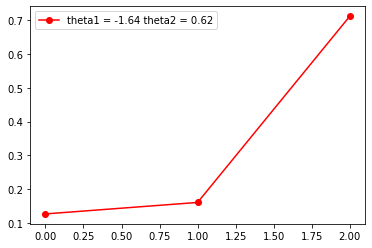

In [8]:
model_beta = WeightMethod().ExpAlmonWeights([out1.params['theta1'], out1.params['theta2']], feat.shape[1])

print('A modellből kapott theta paraméterek ábrázolása')

plt.plot(model_beta, 'ro-', label = 'theta1 = '+ str(round(out1.params['theta1'].value,2)) + ' theta2 = ' + str(round(out1.params['theta2'].value,2)))
plt.legend(loc = 'best')
plt.show()

In [9]:
print('A modell jóságára a score-ok:')
print('R2 score of this model: ', round(r2_score(data, fit1), 6))
print('MSE of this model: ', round(mean_squared_error(data, fit1), 6))
print('Mean Absolute Deviation (MAD) of this model: ', round(np.mean(np.absolute(fit1 - np.mean(fit1))), 6))

A modell jóságára a score-ok:
R2 score of this model:  0.046662
MSE of this model:  4e-05
Mean Absolute Deviation (MAD) of this model:  0.000906


In [10]:
print('''
==============================================
                   | Paraméterek |
----------------------------------------------
N Function Calls   |   %3i       |
Chi-square         |   %.4f    |
   b0              |   %.4f    |
   b1              |   %.4f    |
   theta1          |   %.4f   |
   theta2          |   %.4f    |
----------------------------------------------
''' % (out1.nfev,
       out1.chisqr,
       out1.params['b0'],
       out1.params['b1'],
       out1.params['theta1'], 
       out1.params['theta2']))


                   | Paraméterek |
----------------------------------------------
N Function Calls   |   190       |
Chi-square         |   0.0032    |
   b0              |   0.0088    |
   b1              |   0.5683    |
   theta1          |   -1.6368   |
   theta2          |   0.6244    |
----------------------------------------------



# Unrestricted MIDAS

### Most nézzük meg mit mutat az egyszerű lineáris regressziós modell az adatainkra

In [11]:
model_u_midas = LinReg(feat, data)
coeff = model_u_midas.coeff()
print('Béták: ',coeff)
fit2 = np.matmul(feat, coeff[1:])+coeff[0]

Béták:  [ 0.00903695 -0.20807939  0.38473509  0.26681888]


In [12]:
print('A modell jóságára a score-ok:')
print('R2 score of this model: ', round(r2_score(data, fit2), 6))
print('MSE of this model: ', round(mean_squared_error(data, fit2), 6))
print('Mean Absolute Deviation (MAD) of this model: ', round(np.mean(np.absolute(fit2 - np.mean(fit2))), 6))

A modell jóságára a score-ok:
R2 score of this model:  0.060489
MSE of this model:  4e-05
Mean Absolute Deviation (MAD) of this model:  0.001083


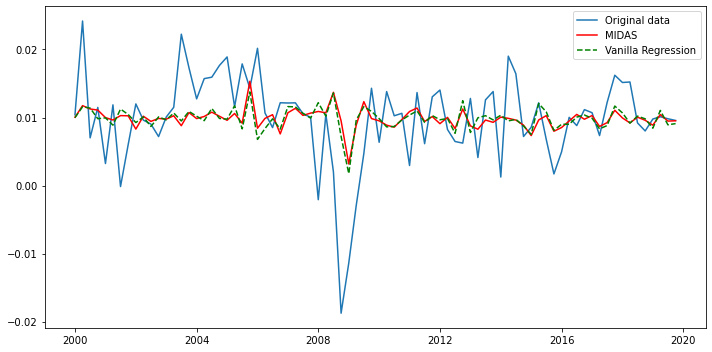

In [13]:
plt.figure().set_size_inches(10, 5)
plt.plot(df1.Date[1:], data, label = 'Original data')
plt.plot(df1.Date[1:], fit1, 'r-', label = 'MIDAS')
plt.plot(df1.Date[1:], fit2, 'g--', label = 'Vanilla Regression')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()